# Kings County Housing Prices Bakeoff

Below are the organized steps I took to preform my EDA and evaluate my model to predict King County Housing Prices.


## Step 1: Read in Data

In [275]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.api as sm
import warnings
import folium
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf
import scipy.stats as stats
pd.set_option('display.max_columns', 300)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
warnings.filterwarnings("ignore")

In [276]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [193]:
org_hous_df=pd.read_csv('Data/kc_house_data_train.csv', index_col='id').drop('Unnamed: 0', axis=1)
org_hous_df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,,,,,,,,,,,,,,,,,,,,
2591820310,20141006T000000,365000.00,4,2.25,2070,8893,2.00,0,0,4,8,2070,0,1986,0,98058,47.44,-122.16,2390,7700
7974200820,20140821T000000,865000.00,5,3.00,2900,6730,1.00,0,0,5,8,1830,1070,1977,0,98115,47.68,-122.28,2370,6283
7701450110,20140815T000000,1038000.00,4,2.50,3770,10893,2.00,0,2,3,11,3770,0,1997,0,98006,47.56,-122.13,3710,9685
9522300010,20150331T000000,1490000.00,3,3.50,4560,14608,2.00,0,2,3,12,4560,0,1990,0,98034,47.70,-122.23,4050,14226
9510861140,20140714T000000,711000.00,3,2.50,2550,5376,2.00,0,0,3,9,2550,0,2004,0,98052,47.66,-122.08,2250,4050


In [194]:
top5codes_price = org_hous_df.groupby("zipcode")["price"].mean().sort_values(ascending = False)[:5]
mean_price = org_hous_df.price.mean()
print(top5codes_price)

zipcode
98039   2202790.00
98004   1396882.89
98040   1183018.00
98112   1119457.66
98102    933671.47
Name: price, dtype: float64


In [195]:
count_by_zip = org_hous_df.groupby("zipcode")["price"].count().sort_values(ascending = False)[:70]
count_by_zip

zipcode
98052    474
98115    465
98103    461
98038    455
98117    437
        ... 
98102     80
98010     74
98024     65
98148     43
98039     42
Name: price, Length: 70, dtype: int64

In [196]:
mean_price_by_zip = org_hous_df.groupby("zipcode")["price"].mean().sort_values(ascending = False)[:70]
mean_price_by_zip = mean_price_by_zip.to_frame()
mean_price_by_zip['count'] = count_by_zip
mean_price_by_zip

,price,count
zipcode,,
98039,2202790.00,42
98004,1396882.89,237
98040,1183018.00,229
98112,1119457.66,216
98102,933671.47,80
...,...,...
98001,281998.76,284
98148,272082.33,43
98032,251602.23,103


## Step 2: Exploratory Data Analysis 
    
Become familiar with the data.  Look to see if there are any extreme values.  

Additionally create data visualizations to determine if there are any relationships between your features and your target variables.  

In [198]:
org_hous_df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,17290.00,17290.00,17290.00,17290.00,17290.00,17290.00,17290.00,17290.00,17290.00,17290.00,17290.00,17290.00,17290.00,17290.00,17290.00,17290.00,17290.00,17290.00,17290.00
mean,540739.55,3.37,2.11,2081.46,15243.40,1.49,0.01,0.24,3.41,7.65,1789.31,292.16,1970.79,83.81,98078.19,47.56,-122.21,1987.99,12873.48
std,373318.98,0.94,0.77,920.02,42304.62,0.54,0.09,0.78,0.65,1.17,829.27,443.15,29.34,400.33,53.61,0.14,0.14,684.80,27227.44
min,75000.00,0.00,0.00,290.00,572.00,1.00,0.00,0.00,1.00,1.00,290.00,0.00,1900.00,0.00,98001.00,47.16,-122.52,399.00,659.00
25%,321000.00,3.00,1.50,1430.00,5081.25,1.00,0.00,0.00,3.00,7.00,1200.00,0.00,1951.00,0.00,98033.00,47.47,-122.33,1490.00,5111.25
50%,450000.00,3.00,2.25,1920.00,7642.00,1.50,0.00,0.00,3.00,7.00,1560.00,0.00,1974.00,0.00,98065.00,47.57,-122.23,1840.00,7622.50
75%,645000.00,4.00,2.50,2550.00,10725.75,2.00,0.00,0.00,4.00,8.00,2214.50,560.00,1996.00,0.00,98118.00,47.68,-122.13,2360.00,10101.75
max,7700000.00,33.00,8.00,13540.00,1651359.00,3.50,1.00,4.00,5.00,13.00,9410.00,4820.00,2015.00,2015.00,98199.00,47.78,-121.31,6210.00,858132.00


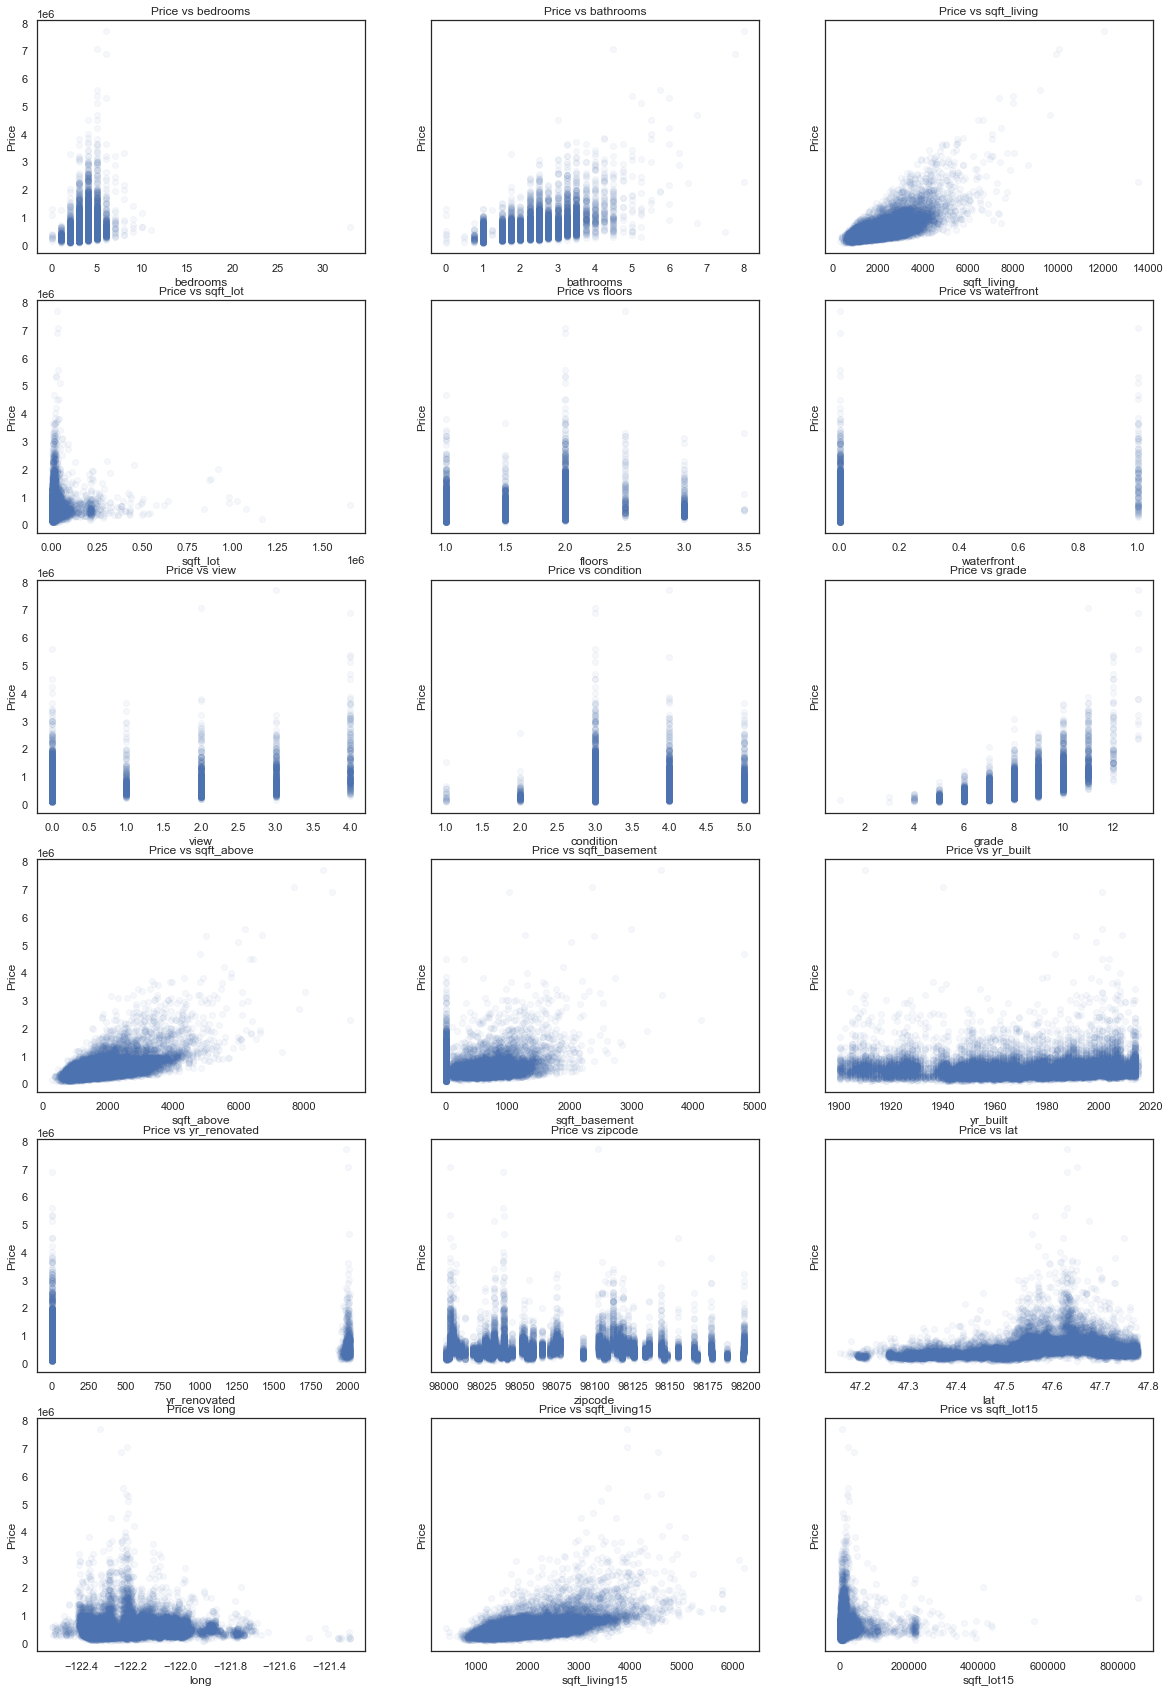

In [199]:
#Identify colinearity for all features with price with plots
fig, axes = plt.subplots(6, 3, figsize=(20,30), sharey=True)
for ax, column in zip(axes.flatten(), org_hous_df.columns[2:]):
    ax.scatter(org_hous_df[column], org_hous_df['price'], label=column, alpha=.05)
    ax.set_title(f'Price vs {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Price')

<AxesSubplot:xlabel='view'>

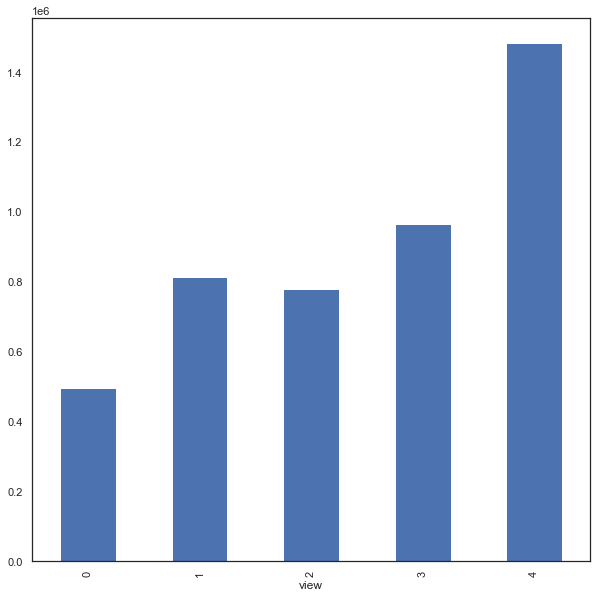

In [200]:
org_hous_df.groupby("view")["price"].mean().plot(kind='bar', figsize=(10,10))

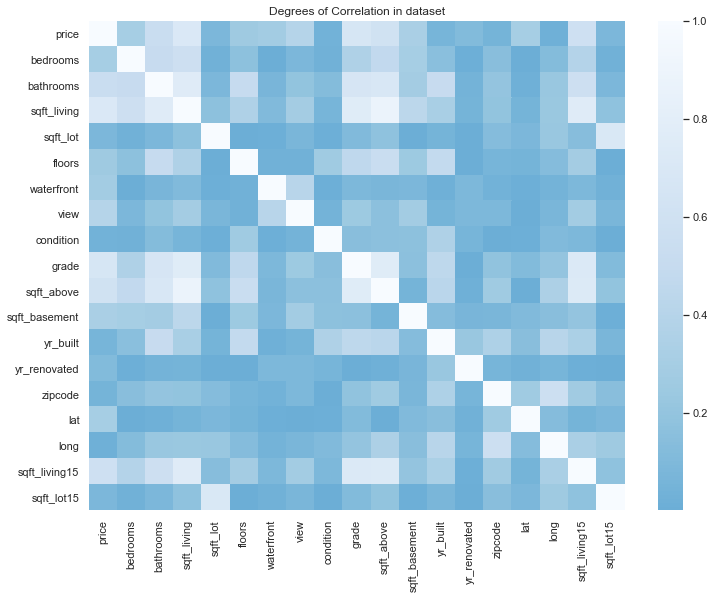

In [201]:
corr = org_hous_df.corr().abs()
sns.set(rc={'figure.figsize':(12,9)})
sns.heatmap(corr[:20], xticklabels=corr[:20].columns, \
            yticklabels=corr[:20].columns, \
            annot=False, cmap='Blues_r', center= 0)
plt.title('Degrees of Correlation in dataset');

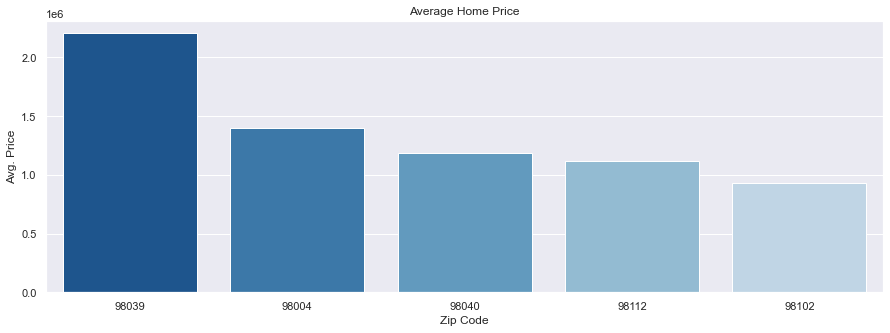

In [202]:
sns.set_palette('Blues_r')
x = ['98039', '98004', '98040', '98112', '98102']
y = [2.202790e+06, 1.396883e+06, 1.183018e+06, 1.119458e+06, 9.336715e+05]
fig, ax = plt.subplots(figsize = (15, 5))
ax = sns.barplot(x=x,y=y, data=org_hous_df)
ax.ticklabel_format(style='scientific', axis='y')

ax.set(xlabel='Zip Code', ylabel='Avg. Price')
plt.title("Average Home Price")
plt.show()

[(0.0, 5000000.0),
 Text(0.5, 0, 'Sale Price'),
 Text(0, 0.5, 'Sale Count'),
 Text(0.5, 1.0, 'Sale Distribution')]

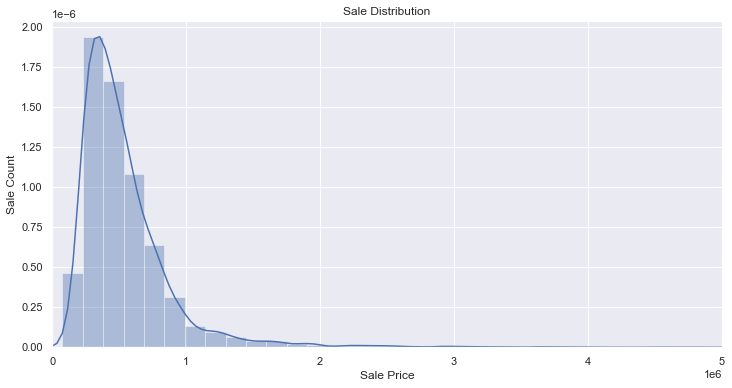

In [203]:
fig, ax = plt.subplots(figsize = (12,6))
sns.distplot(org_hous_df['price'], bins=50, color = 'b')
ax.set(xlim=[0, 5000000], xlabel='Sale Price', ylabel='Sale Count',
       title='Sale Distribution')

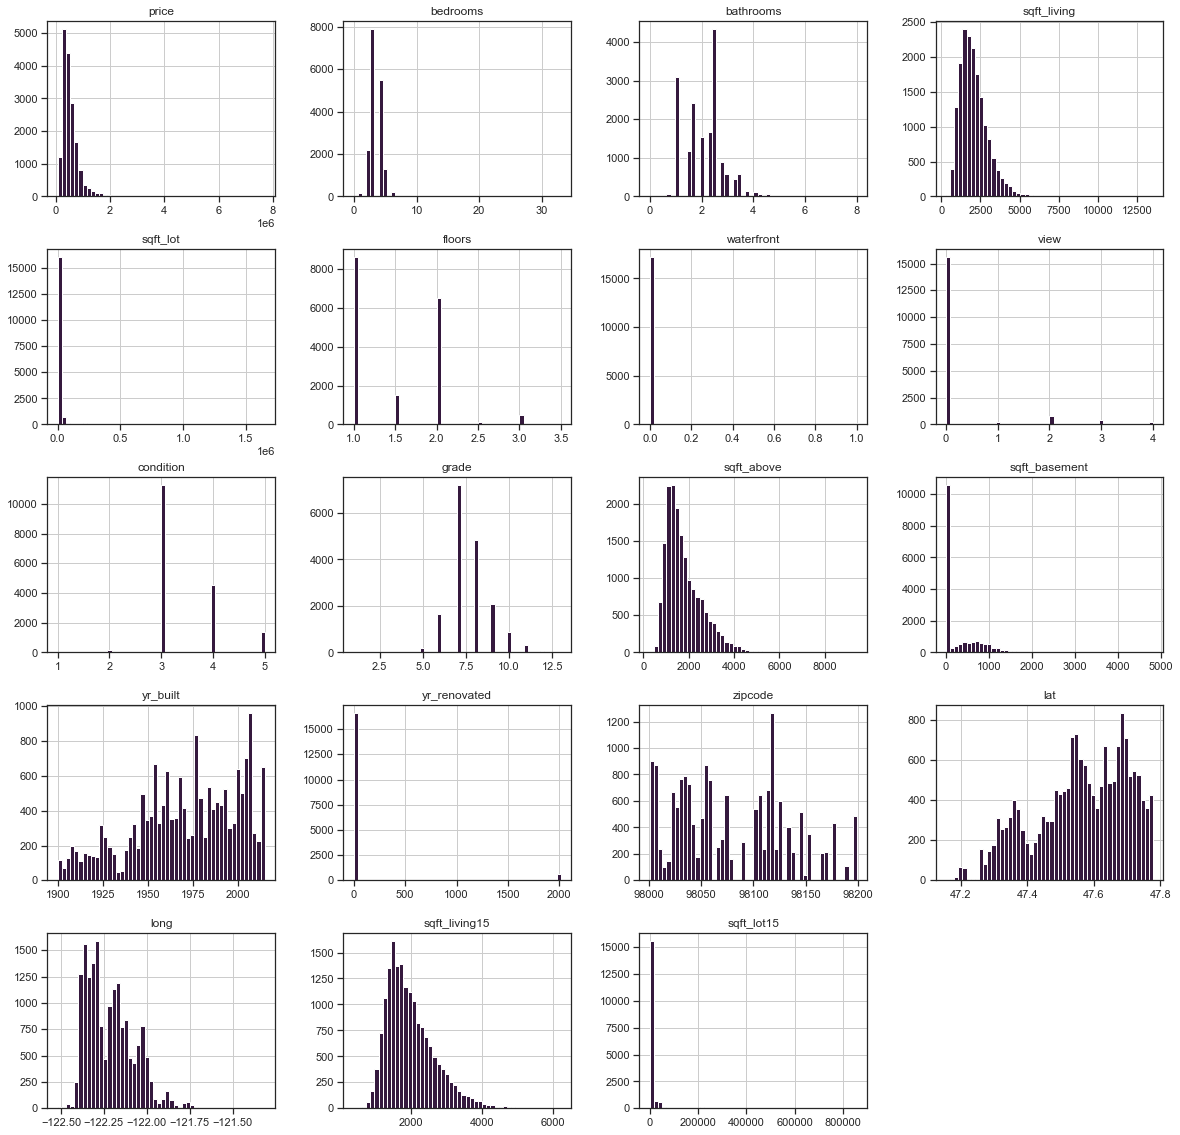

In [204]:
sns.set_theme(style='ticks', palette="rocket")
org_hous_df.hist(bins=50, figsize=(20,20))
plt.show()

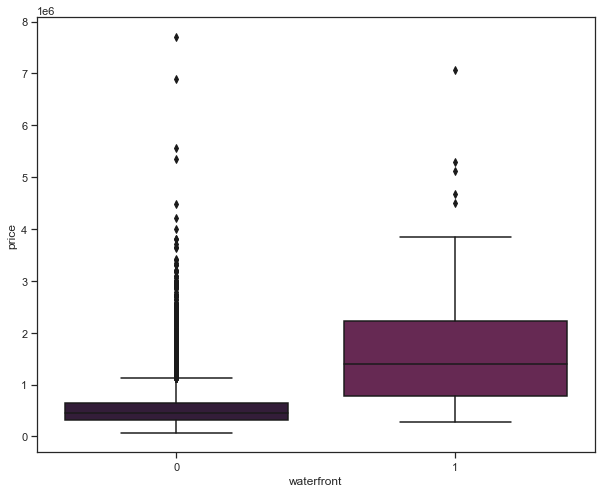

In [205]:
var = 'waterfront'
data = pd.concat([org_hous_df['price'], org_hous_df[var]], axis=1)
fig, ax = plt.subplots(figsize=(10,8))
fig = sns.boxplot(x=var, y='price', data=data)

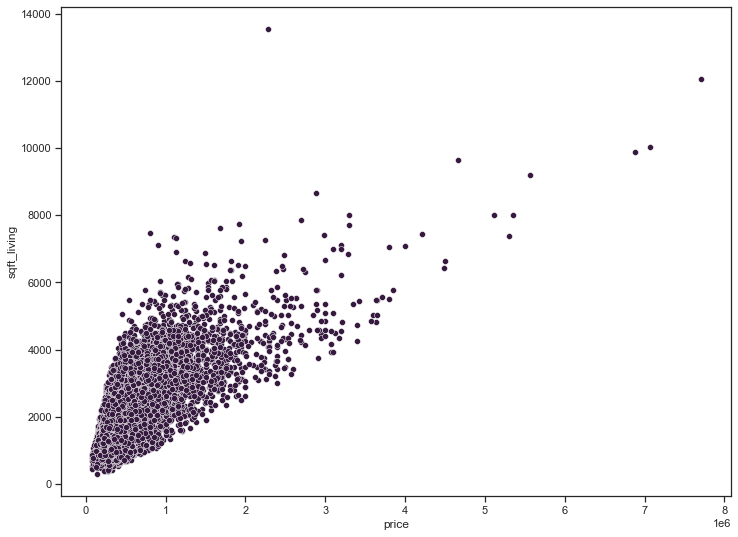

In [206]:
sns.scatterplot(data = org_hous_df, x = org_hous_df['price'], y = org_hous_df['sqft_living'])

plt.show()

In [207]:
#folium Map using coordinates
kc_map = folium.Map(location = [47.5480, -121.9836], tiles = 'OpenStreetMap', zoom_start = 9)

kc_coord = list(zip(org_hous_df['lat'], org_hous_df['long']))

for coord in kc_coord:
    folium.Marker(location = coord).add_to(kc_map)

#kc_map

### Step 2.1: Statistical Tests to Find Valueable Features

In [290]:
no_bedrooms = org_hous_df[org_hous_df['bedrooms'] == 0]['price']
no_bathrooms = org_hous_df[org_hous_df['bathrooms'] == 0]['price']
bathroom_pvalue = stats.ttest_ind(no_bedrooms, no_bathrooms)[1]
bathroom_pvalue

0.6824544554785027

In [295]:
alpha = 0.05 
formula = 'price~zipcode_98052 + zipcode_98039'
lm_condition = smf.ols(formula, org_hous_df).fit()
anova_condition = sm.stats.anova_lm(lm_condition, typ=2)

if anova_condition["PR(>F)"][0] < alpha:
    print("The zipcode has a statistically significant impact on average property value")
    print("Conditions F-statisic Probability: ", anova_condition ["PR(>F)"][0] )

The zipcode has a statistically significant impact on average property value
Conditions F-statisic Probability:  3.281485370147009e-11


In [296]:
alpha = 0.05 
formula = 'price ~ C(bedrooms) + C(bathrooms) + C(sqft_living)'
lm = ols(formula, org_hous_df).fit()
anova_table = sm.stats.anova_lm(lm, typ=2)
print(anova_table)

if anova_table["PR(>F)"][0] < alpha:
    print("The amount of bedrooms and bathrooms has a statistically significant impact on average property sale value")

                           sum_sq       df     F  PR(>F)
C(bedrooms)     14997415954690.44    11.00 26.88    0.00
C(bathrooms)    49125744912508.54    29.00 33.40    0.00
C(sqft_living) 742181678852477.38   946.00 15.47    0.00
Residual       827187428779365.25 16309.00   nan     nan
The amount of bedrooms and bathrooms has a statistically significant impact on average property sale value


## Step 3: Clean up any issues (extreme values, etc.) with the data.  

Remember that you can't just delete rows with extreme values. Similar observations might be present in the holdout data set, and you can't just delete those rows and not have a prediction for it. 

bedrooms - 33 bedroom house on Google Maps seems to be typo for a 3 bedroom house, twelve "studios" with no bedrooms
bathrooms - eight with no bathrooms

In [208]:
#correct 33 bedroom home
org_hous_df['bedrooms'].replace(33, 3, inplace=True)

## Step 4: Generate new features that you think could be important.

After doing this, you will want to go back to steps 2 and 3 to investigate these new features.

In [209]:
#yard_space column
org_hous_df['yard_space'] = org_hous_df.sqft_lot - (org_hous_df.sqft_living / org_hous_df.floors)

In [210]:
#multi_floor_column
org_hous_df['multi_floor'] = [0 if x == 1 else 1 for x in org_hous_df.floors] 

In [211]:
#Basement coulumn
org_hous_df['has_basement'] = [0 if x == 0 else 1 for x in org_hous_df.sqft_basement]

In [212]:
#sale_month column to explore affeect of seasons
org_hous_df['sale_month'] = pd.DatetimeIndex(org_hous_df['date']).month

In [213]:
#Year Renovated coulumn
org_hous_df['yr_built_reno'] = np.where((org_hous_df['yr_built'] < 1974) & (org_hous_df['yr_renovated'] == 0), 0,1)

In [214]:
org_hous_df

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,yard_space,multi_floor,has_basement,sale_month,yr_built_reno
id,,,,,,,,,,,,,,,,,,,,,,,,,
2591820310,20141006T000000,365000.00,4,2.25,2070,8893,2.00,0,0,4,8,2070,0,1986,0,98058,47.44,-122.16,2390,7700,7858.00,1,0,10,1
7974200820,20140821T000000,865000.00,5,3.00,2900,6730,1.00,0,0,5,8,1830,1070,1977,0,98115,47.68,-122.28,2370,6283,3830.00,0,1,8,1
7701450110,20140815T000000,1038000.00,4,2.50,3770,10893,2.00,0,2,3,11,3770,0,1997,0,98006,47.56,-122.13,3710,9685,9008.00,1,0,8,1
9522300010,20150331T000000,1490000.00,3,3.50,4560,14608,2.00,0,2,3,12,4560,0,1990,0,98034,47.70,-122.23,4050,14226,12328.00,1,0,3,1
9510861140,20140714T000000,711000.00,3,2.50,2550,5376,2.00,0,0,3,9,2550,0,2004,0,98052,47.66,-122.08,2250,4050,4101.00,1,0,7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
627300195,20150303T000000,750000.00,5,2.50,3240,9960,1.00,0,1,3,8,2020,1220,1958,0,98008,47.59,-122.11,2730,10400,6720.00,0,1,3,0
8819900270,20140520T000000,440000.00,2,1.75,1300,4000,2.00,0,0,3,7,1300,0,1948,0,98105,47.67,-122.29,1350,4013,3350.00,1,0,5,0
3816300095,20140514T000000,310000.00,3,1.00,1050,9876,1.00,0,0,3,7,1050,0,1953,0,98028,47.76,-122.26,1760,9403,8826.00,0,0,5,0


### 4.1) Identify a categorical variable in the data set and create dummy columns.

In [215]:
# identified zipcode,grade and view
org_hous_df=pd.get_dummies(org_hous_df, columns=['zipcode'], drop_first=True)
org_hous_df=pd.get_dummies(org_hous_df, columns=['grade'], drop_first=True)
org_hous_df=pd.get_dummies(org_hous_df, columns=['view'], drop_first=True)
#sqft of homes sold with the best view
org_hous_df['bestview_sqftliving'] =org_hous_df['view_4']*org_hous_df['sqft_living']
#zipcode with 474 houses sqft
org_hous_df['biggestzipcode_sqftliving'] =org_hous_df['zipcode_98052']*org_hous_df['sqft_living']
org_hous_df

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,yard_space,multi_floor,has_basement,sale_month,yr_built_reno,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,zipcode_98011,zipcode_98014,zipcode_98019,zipcode_98022,zipcode_98023,zipcode_98024,zipcode_98027,zipcode_98028,zipcode_98029,zipcode_98030,zipcode_98031,zipcode_98032,zipcode_98033,zipcode_98034,zipcode_98038,zipcode_98039,zipcode_98040,zipcode_98042,zipcode_98045,zipcode_98052,zipcode_98053,zipcode_98055,zipcode_98056,zipcode_98058,zipcode_98059,zipcode_98065,zipcode_98070,zipcode_98072,zipcode_98074,zipcode_98075,zipcode_98077,zipcode_98092,zipcode_98102,zipcode_98103,zipcode_98105,zipcode_98106,zipcode_98107,zipcode_98108,zipcode_98109,zipcode_98112,zipcode_98115,zipcode_98116,zipcode_98117,zipcode_98118,zipcode_98119,zipcode_98122,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199,grade_3,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,grade_10,grade_11,grade_12,grade_13,view_1,view_2,view_3,view_4,bestview_sqftliving,biggestzipcode_sqftliving
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2591820310,20141006T000000,365000.00,4,2.25,2070,8893,2.00,0,4,2070,0,1986,0,47.44,-122.16,2390,7700,7858.00,1,0,10,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
7974200820,20140821T000000,865000.00,5,3.00,2900,6730,1.00,0,5,1830,1070,1977,0,47.68,-122.28,2370,6283,3830.00,0,1,8,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
7701450110,20140815T000000,1038000.00,4,2.50,3770,10893,2.00,0,3,3770,0,1997,0,47.56,-122.13,3710,9685,9008.00,1,0,8,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
9522300010,20150331T000000,1490000.00,3,3.50,4560,14608,2.00,0,3,4560,0,1990,0,47.70,-122.23,4050,14226,12328.00,1,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
9510861140,20140714T000000,711000.00,3,2.50,2550,5376,2.00,0,3,2550,0,2004,0,47.66,-122.08,2250,4050,4101.00,1,0,7,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
627300195,20150303T000000,750000.00,5,2.50,3240,9960,1.00,0,3,2020,1220,1958,0,47.59,-122.11,2730,10400,6720.00,0,1,3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
8819900270,20140520T000000,440000.00,2,1.75,1300,4000,2.00,0,3,1300,0,1948,0,47.67,-122.29,1350,4013,3350.00,1,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3816300095,20140514T000000,310000.00,3,1.00,1050,9876,1.00,0

### 4.3) There are columns for when the house was built and when it was renovated.  How could you use these columns to create a new column?

In [216]:
org_hous_df

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,yard_space,multi_floor,has_basement,sale_month,yr_built_reno,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,zipcode_98011,zipcode_98014,zipcode_98019,zipcode_98022,zipcode_98023,zipcode_98024,zipcode_98027,zipcode_98028,zipcode_98029,zipcode_98030,zipcode_98031,zipcode_98032,zipcode_98033,zipcode_98034,zipcode_98038,zipcode_98039,zipcode_98040,zipcode_98042,zipcode_98045,zipcode_98052,zipcode_98053,zipcode_98055,zipcode_98056,zipcode_98058,zipcode_98059,zipcode_98065,zipcode_98070,zipcode_98072,zipcode_98074,zipcode_98075,zipcode_98077,zipcode_98092,zipcode_98102,zipcode_98103,zipcode_98105,zipcode_98106,zipcode_98107,zipcode_98108,zipcode_98109,zipcode_98112,zipcode_98115,zipcode_98116,zipcode_98117,zipcode_98118,zipcode_98119,zipcode_98122,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199,grade_3,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,grade_10,grade_11,grade_12,grade_13,view_1,view_2,view_3,view_4,bestview_sqftliving,biggestzipcode_sqftliving
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2591820310,20141006T000000,365000.00,4,2.25,2070,8893,2.00,0,4,2070,0,1986,0,47.44,-122.16,2390,7700,7858.00,1,0,10,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
7974200820,20140821T000000,865000.00,5,3.00,2900,6730,1.00,0,5,1830,1070,1977,0,47.68,-122.28,2370,6283,3830.00,0,1,8,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
7701450110,20140815T000000,1038000.00,4,2.50,3770,10893,2.00,0,3,3770,0,1997,0,47.56,-122.13,3710,9685,9008.00,1,0,8,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
9522300010,20150331T000000,1490000.00,3,3.50,4560,14608,2.00,0,3,4560,0,1990,0,47.70,-122.23,4050,14226,12328.00,1,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
9510861140,20140714T000000,711000.00,3,2.50,2550,5376,2.00,0,3,2550,0,2004,0,47.66,-122.08,2250,4050,4101.00,1,0,7,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
627300195,20150303T000000,750000.00,5,2.50,3240,9960,1.00,0,3,2020,1220,1958,0,47.59,-122.11,2730,10400,6720.00,0,1,3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
8819900270,20140520T000000,440000.00,2,1.75,1300,4000,2.00,0,3,1300,0,1948,0,47.67,-122.29,1350,4013,3350.00,1,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3816300095,20140514T000000,310000.00,3,1.00,1050,9876,1.00,0

In [217]:
#ols(formula='price~C(zipcode)+C(view)+C(grade)+sqft_living', data= org_hous_df).fit().summary()

### <ins>Non-linear transformations</ins>

### 4.4) Create a polynomial feature for two of your continuous variables.

In [218]:
org_hous_df['sqft_living^3'] = org_hous_df['sqft_living']**3
org_hous_df['sqft_living^2'] = org_hous_df['sqft_living']**2
org_hous_df['sqft_basement^2'] = org_hous_df['sqft_basement']**2
org_hous_df

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,yard_space,multi_floor,has_basement,sale_month,yr_built_reno,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,zipcode_98011,zipcode_98014,zipcode_98019,zipcode_98022,zipcode_98023,zipcode_98024,zipcode_98027,zipcode_98028,zipcode_98029,zipcode_98030,zipcode_98031,zipcode_98032,zipcode_98033,zipcode_98034,zipcode_98038,zipcode_98039,zipcode_98040,zipcode_98042,zipcode_98045,zipcode_98052,zipcode_98053,zipcode_98055,zipcode_98056,zipcode_98058,zipcode_98059,zipcode_98065,zipcode_98070,zipcode_98072,zipcode_98074,zipcode_98075,zipcode_98077,zipcode_98092,zipcode_98102,zipcode_98103,zipcode_98105,zipcode_98106,zipcode_98107,zipcode_98108,zipcode_98109,zipcode_98112,zipcode_98115,zipcode_98116,zipcode_98117,zipcode_98118,zipcode_98119,zipcode_98122,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199,grade_3,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,grade_10,grade_11,grade_12,grade_13,view_1,view_2,view_3,view_4,bestview_sqftliving,biggestzipcode_sqftliving,sqft_living^3,sqft_living^2,sqft_basement^2
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2591820310,20141006T000000,365000.00,4,2.25,2070,8893,2.00,0,4,2070,0,1986,0,47.44,-122.16,2390,7700,7858.00,1,0,10,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,8869743000,4284900,0
7974200820,20140821T000000,865000.00,5,3.00,2900,6730,1.00,0,5,1830,1070,1977,0,47.68,-122.28,2370,6283,3830.00,0,1,8,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,24389000000,8410000,1144900
7701450110,20140815T000000,1038000.00,4,2.50,3770,10893,2.00,0,3,3770,0,1997,0,47.56,-122.13,3710,9685,9008.00,1,0,8,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,53582633000,14212900,0
9522300010,20150331T000000,1490000.00,3,3.50,4560,14608,2.00,0,3,4560,0,1990,0,47.70,-122.23,4050,14226,12328.00,1,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,94818816000,20793600,0
9510861140,20140714T000000,711000.00,3,2.50,2550,5376,2.00,0,3,2550,0,2004,0,47.66,-122.08,2250,4050,4101.00,1,0,7,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2550,16581375000,6502500,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
627300195,20150303T000000,750000.00,5,2.50,3240,9960,1.00,0,3,2020,1220,1958,0,47.59,-122.11,2730,10400,6720.00,0,1,3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,34012224000,10497600,1488400
8819900270,20140520T000000,440000.00,2,1.75,1300,4000,2.00,0,3,1300,0,1948,0,47.67,-122.29,1350,4013,3350.00,1,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

### 4.5) Create an interaction feature between a binary variable (dummy variable) and a continuous variable.

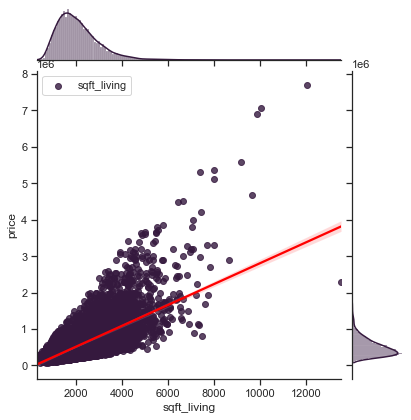

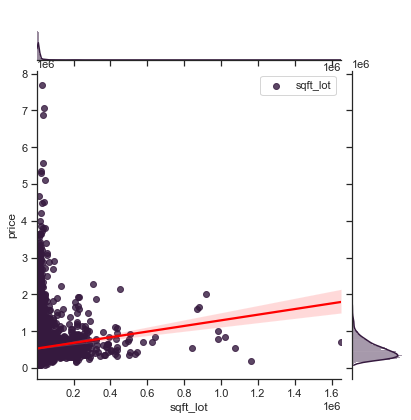

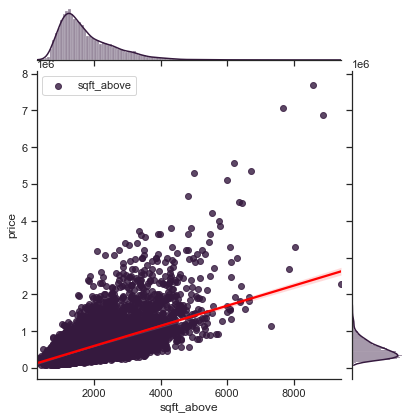

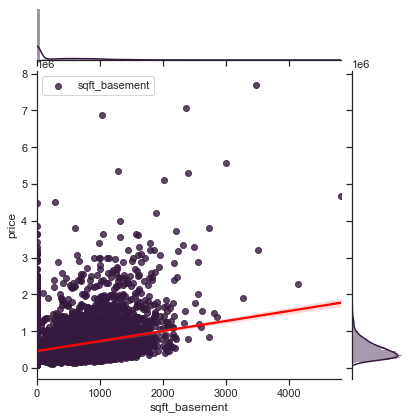

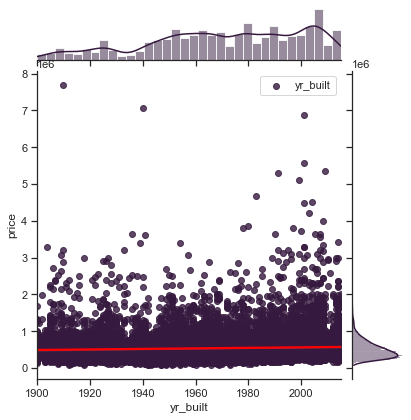

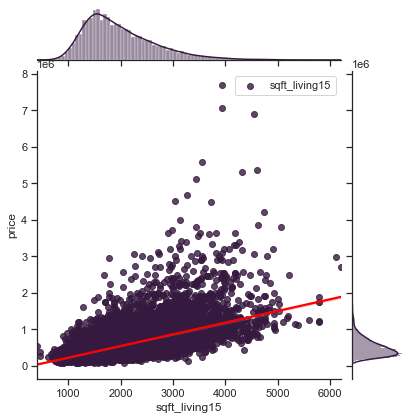

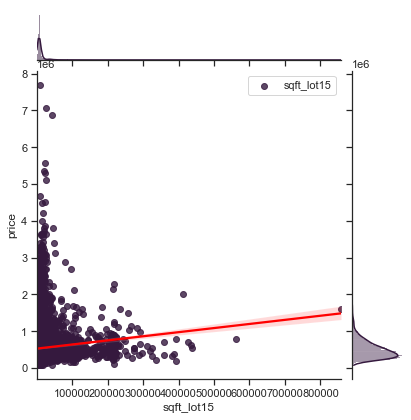

In [219]:
continuous = ['sqft_living','sqft_lot','sqft_above','sqft_basement','yr_built','sqft_living15','sqft_lot15']

for column in continuous:
    sns.jointplot(x=column, y="price", data=org_hous_df, kind='reg', label=column,joint_kws={'line_kws':{'color':'red'}})
    plt.legend()
    plt.show()

### 4.6) SKLearn Identifying Features 

In [220]:
#save cleaned df
org_hous_df.to_csv('~/Data', index=0)
org_hous_df

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,yard_space,multi_floor,has_basement,sale_month,yr_built_reno,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,zipcode_98011,zipcode_98014,zipcode_98019,zipcode_98022,zipcode_98023,zipcode_98024,zipcode_98027,zipcode_98028,zipcode_98029,zipcode_98030,zipcode_98031,zipcode_98032,zipcode_98033,zipcode_98034,zipcode_98038,zipcode_98039,zipcode_98040,zipcode_98042,zipcode_98045,zipcode_98052,zipcode_98053,zipcode_98055,zipcode_98056,zipcode_98058,zipcode_98059,zipcode_98065,zipcode_98070,zipcode_98072,zipcode_98074,zipcode_98075,zipcode_98077,zipcode_98092,zipcode_98102,zipcode_98103,zipcode_98105,zipcode_98106,zipcode_98107,zipcode_98108,zipcode_98109,zipcode_98112,zipcode_98115,zipcode_98116,zipcode_98117,zipcode_98118,zipcode_98119,zipcode_98122,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199,grade_3,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,grade_10,grade_11,grade_12,grade_13,view_1,view_2,view_3,view_4,bestview_sqftliving,biggestzipcode_sqftliving,sqft_living^3,sqft_living^2,sqft_basement^2
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2591820310,20141006T000000,365000.00,4,2.25,2070,8893,2.00,0,4,2070,0,1986,0,47.44,-122.16,2390,7700,7858.00,1,0,10,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,8869743000,4284900,0
7974200820,20140821T000000,865000.00,5,3.00,2900,6730,1.00,0,5,1830,1070,1977,0,47.68,-122.28,2370,6283,3830.00,0,1,8,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,24389000000,8410000,1144900
7701450110,20140815T000000,1038000.00,4,2.50,3770,10893,2.00,0,3,3770,0,1997,0,47.56,-122.13,3710,9685,9008.00,1,0,8,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,53582633000,14212900,0
9522300010,20150331T000000,1490000.00,3,3.50,4560,14608,2.00,0,3,4560,0,1990,0,47.70,-122.23,4050,14226,12328.00,1,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,94818816000,20793600,0
9510861140,20140714T000000,711000.00,3,2.50,2550,5376,2.00,0,3,2550,0,2004,0,47.66,-122.08,2250,4050,4101.00,1,0,7,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2550,16581375000,6502500,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
627300195,20150303T000000,750000.00,5,2.50,3240,9960,1.00,0,3,2020,1220,1958,0,47.59,-122.11,2730,10400,6720.00,0,1,3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,34012224000,10497600,1488400
8819900270,20140520T000000,440000.00,2,1.75,1300,4000,2.00,0,3,1300,0,1948,0,47.67,-122.29,1350,4013,3350.00,1,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [221]:
df_features = org_hous_df.filter(org_hous_df.columns)
df_features.drop(columns=['lat','long','date','price'], inplace=True)

In [222]:
target = org_hous_df['price']

In [223]:
len(df_features.columns)

107

In [224]:
df_features.shape

(17290, 107)

In [225]:
from sklearn.linear_model import LinearRegression

#instantiate a linear regression object
lm = LinearRegression()

#fit the linear regression to the data
lm = lm.fit(df_features, target)

#access output
print(lm.intercept_)
print(lm.coef_)
print("R^2: ", lm.score(df_features, target))

351680.85624963883
[-5.48207374e+03  2.79307078e+04  4.59223440e+01 -8.91280885e+00
 -3.95283864e+04  5.90946283e+05  3.34991915e+04 -2.92731901e+01
 -1.58879416e+01 -2.00454552e+02  3.31014225e+01  3.02918126e+01
 -7.28043698e-02  9.10259765e+00  1.11876497e+04 -1.37851491e+04
 -2.67751275e+03 -8.75198905e+03  4.82488444e+03 -1.12730996e+04
  7.67589044e+05  2.97530349e+05  2.42213504e+05  2.48321251e+05
  2.51838577e+05  5.95563168e+04  1.38300401e+05  9.98640291e+04
  9.53898937e+04 -6.33029160e+03 -3.22496412e+04  1.55723269e+05
  1.61216185e+05  1.32581100e+05  2.13833340e+05  4.50909819e+03
  1.31022969e+04  1.46933983e+03  3.52101106e+05  1.99394854e+05
  3.60516164e+04  1.17906398e+06  4.78509304e+05  6.13651321e+03
  9.71315875e+04  2.93255953e+05  1.98166973e+05  4.06746138e+04
  8.83289483e+04  3.22528096e+04  7.93249459e+04  8.84523486e+04
  2.72158883e+04  1.60130017e+05  1.79010917e+05  1.65437824e+05
  1.05724383e+05 -2.59869683e+04  4.82021684e+05  3.41663206e+05
  4.69

In [226]:
from sklearn.preprocessing import PolynomialFeatures

#poly = PolynomialFeatures(degree=2, include_bias=False)

In [227]:
#poly_data = poly.fit_transform(df_features)

In [228]:
df_features.isna().any().sum()

0

## Step 5: Model Evaluation



## 5.1)  Fit an initial model and check the errors to see if the model assumptions are being met. If need be, go back to steps 3 and 4 to improve your model. 

In [229]:
#ols(formula='price~(zipcode)+(grade)+(view)+sqft_living', data=df_features).fit().summary()

In [230]:
#df_features.drop(columns='id', inplace=True)

In [232]:
#poly_columns = poly.get_feature_names(df_features.columns)

In [237]:
#len(poly_columns)

In [238]:
df_features

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15,yard_space,multi_floor,has_basement,sale_month,yr_built_reno,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,zipcode_98011,zipcode_98014,zipcode_98019,zipcode_98022,zipcode_98023,zipcode_98024,zipcode_98027,zipcode_98028,zipcode_98029,zipcode_98030,zipcode_98031,zipcode_98032,zipcode_98033,zipcode_98034,zipcode_98038,zipcode_98039,zipcode_98040,zipcode_98042,zipcode_98045,zipcode_98052,zipcode_98053,zipcode_98055,zipcode_98056,zipcode_98058,zipcode_98059,zipcode_98065,zipcode_98070,zipcode_98072,zipcode_98074,zipcode_98075,zipcode_98077,zipcode_98092,zipcode_98102,zipcode_98103,zipcode_98105,zipcode_98106,zipcode_98107,zipcode_98108,zipcode_98109,zipcode_98112,zipcode_98115,zipcode_98116,zipcode_98117,zipcode_98118,zipcode_98119,zipcode_98122,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199,grade_3,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,grade_10,grade_11,grade_12,grade_13,view_1,view_2,view_3,view_4,bestview_sqftliving,biggestzipcode_sqftliving,sqft_living^3,sqft_living^2,sqft_basement^2
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2591820310,4,2.25,2070,8893,2.00,0,4,2070,0,1986,0,2390,7700,7858.00,1,0,10,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,8869743000,4284900,0
7974200820,5,3.00,2900,6730,1.00,0,5,1830,1070,1977,0,2370,6283,3830.00,0,1,8,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,24389000000,8410000,1144900
7701450110,4,2.50,3770,10893,2.00,0,3,3770,0,1997,0,3710,9685,9008.00,1,0,8,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,53582633000,14212900,0
9522300010,3,3.50,4560,14608,2.00,0,3,4560,0,1990,0,4050,14226,12328.00,1,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,94818816000,20793600,0
9510861140,3,2.50,2550,5376,2.00,0,3,2550,0,2004,0,2250,4050,4101.00,1,0,7,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2550,16581375000,6502500,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
627300195,5,2.50,3240,9960,1.00,0,3,2020,1220,1958,0,2730,10400,6720.00,0,1,3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,34012224000,10497600,1488400
8819900270,2,1.75,1300,4000,2.00,0,3,1300,0,1948,0,1350,4013,3350.00,1,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2197000000,1690000,0
3816300095,3,1.00,1050,9876,1.00,0,3,1050,0,1953,0,1760,9403,8826.00,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [240]:
#df_poly = pd.DataFrame(poly_data, columns=poly_columns)

In [242]:
#df_poly.head()

In [243]:
#poly_3 = PolynomialFeatures(degree=3, include_bias=False)
#poly3_data = poly_3.fit_transform(df_features)
#poly3_columns = poly_3.get_feature_names(df_features.columns)
#df_poly3 = pd.DataFrame(poly3_data, columns=poly3_columns)

In [245]:
#instantiate a linear regression object
#lm_2 = LinearRegression()

#fit the linear regression to the data
#lm_2 = lm_2.fit(df_poly, target)

#access output
#print(lm_2.intercept_)
#print(lm_2.coef_)
#print("R^2: ", lm_2.score(df_poly, target))

In [248]:
#instantiate a linear regression object
#lm_3 = LinearRegression()

#fit the linear regression to the data
#lm_3 = lm_3.fit(df_poly3, target)

#access output
# print(lm_3.intercept_)
# print(lm_3.coef_)
#print("R^2: ", lm_3.score(df_poly3, target))

In [249]:
df_features.columns

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'condition', 'sqft_above', 'sqft_basement', 'yr_built',
       ...
       'grade_13', 'view_1', 'view_2', 'view_3', 'view_4',
       'bestview_sqftliving', 'biggestzipcode_sqftliving', 'sqft_living^3',
       'sqft_living^2', 'sqft_basement^2'],
      dtype='object', length=107)

### 5.2) Perform a train-test split of the data.

In [250]:
#X_train, X_test, y_train, y_test = train_test_split(df_features, target, random_state=9,test_size=0.3)

In [251]:
X_train, X_test, y_train, y_test = train_test_split(df_features, target, test_size=0.3, random_state=1)
print(len(X_train), len(X_test), len(y_train), len(y_test))

12103 5187 12103 5187


### 5.3) Fit the model to the training data.

In [252]:
y_train

id
2023049218    105500.00
2225059273    975000.00
7853240200    619000.00
9547200530    780000.00
8078460520    608000.00
                ...    
2175100270   1025000.00
5101405465    463000.00
619000100     419000.00
5635100090    379950.00
2734100734    216650.00
Name: price, Length: 12103, dtype: float64

In [253]:
target.head()

id
2591820310    365000.00
7974200820    865000.00
7701450110   1038000.00
9522300010   1490000.00
9510861140    711000.00
Name: price, dtype: float64

In [255]:
#scaler = StandardScaler()

# fit the scaler to the training data
#scaler.fit(X_train)

#transform the training data
##scaled_data = scaler.transform(X_train)

#create dataframe
#X_train = pd.DataFrame(data=scaled_data, columns=df_features.columns)

#transform the testing dat
#X_test = pd.DataFrame(data=scaler.transform(X_test), columns=df_features.columns)

### 5.4) Use the model to predict on the training set and the test set.

### 5.5) Evaluate the training and test predictions using RMSE.

### 5.6) Determine if your model is overfit.

In [256]:
def testntrain_data(df_features, target):
    X_train, X_test, y_train, y_test=train_test_split(df_features, target, random_state=1,test_size=0.3)
    lm = LinearRegression()
    lm.fit(X_train, y_train)
    y_pred_train=lm.predict(X_train)
    y_pred_test = lm.predict(X_test)
    
    train_mae = metrics.mean_absolute_error(y_train, y_pred_train)
    train_mse = metrics.mean_squared_error(y_train, y_pred_train)
    train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_pred_train))
    price_std = target.std()
    
    y_pred = lm.predict(X_test)
    test_mae = metrics.mean_absolute_error(y_test, y_pred_test)
    test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred_test))
    
    
    #RMSE=np.sqrt(metrics.mean_squared_error(y_train, y_pred))
    print ("R^2 Score:", lm.score(X_train, y_train))
    print('Mean Absolute Error  Z:', test_mae/price_std )
    print('Root Mean Squared Error Z:' , test_rmse/price_std)
    print('Training: ', train_rmse, "vs. Testing: ", test_rmse)

In [257]:
df1_rmse = testntrain_data(df_features, target)
df1_rmse

R^2 Score: 0.8425169957023484
Mean Absolute Error  Z: 0.22956237132765517
Root Mean Squared Error Z: 0.3772678553121861
Training:  150753.7680238794 vs. Testing:  140841.25046007725


In [258]:
#check the shape of the results
print("Training set - Features: ", X_train.shape, "Target: ", y_train.shape)
print("Training set - Features: ", X_test.shape, "Target: ",y_test.shape)

Training set - Features:  (12103, 107) Target:  (12103,)
Training set - Features:  (5187, 107) Target:  (5187,)


## Step 6: Utilize some different feature selection techniques before or in conjuction with fitting your models. You will have to repeat steps 5.3 through 5.6 to determine how your new model is performing. 

### 6.1) Utilize a filter method to identify some features to remove from the model.  

In [260]:
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression

selector = SelectKBest(f_regression, k=70)

selector.fit(X_train, y_train)

SelectKBest(k=70, score_func=<function f_regression at 0x7fef38c17af0>)

In [261]:
selector.get_support()

array([ True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True, False, False, False, False,
       False, False,  True,  True, False, False, False, False,  True,
        True,  True,  True, False,  True,  True,  True,  True, False,
        True,  True,  True, False,  True, False, False, False, False,
        True,  True, False,  True,  True, False,  True,  True, False,
       False,  True,  True, False, False, False,  True,  True, False,
       False, False,  True, False, False,  True, False,  True, False,
        True, False,  True,  True,  True,  True, False, False,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

In [ ]:
selected_columns = X_train.columns[selector.get_support()]
removed_columns = X_train.columns[~selector.get_support()]
X_train = X_train[selected_columns]
X_test = X_test[selected_columns]

In [ ]:
print(removed_columns, selected_columns)

In [ ]:
def k_best_test(features, target, k):
    X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=1,test_size=0.2)
    selector = SelectKBest(f_regression, k=k)
    selector.fit(X_train, y_train)
    selector.get_support()
    
    selected_columns = X_train.columns[selector.get_support()]
    removed_columns = X_train.columns[~selector.get_support()]
    X_train = X_train[selected_columns]
    X_test = X_test[selected_columns]
    
    lm_kbest = LinearRegression()
    lm_kbest.fit(X_train[selected_columns], y_train)
    y_train_kbest = lm_kbest.predict(X_train[selected_columns])
    trainK_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_kbest))
    
    y_kbest = lm_kbest.predict(X_test[selected_columns])
    testK_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_kbest))
    
    print('Training Root Mean Squared Error:' , trainK_rmse)
    print('Testing Root Mean Squared Error:' , testK_rmse)

In [ ]:
k_best_test(df_features, target, 100)

### 6.2) After removing the features, re-run Step 5 and see if your new model performs better than the old model.

<AxesSubplot:>

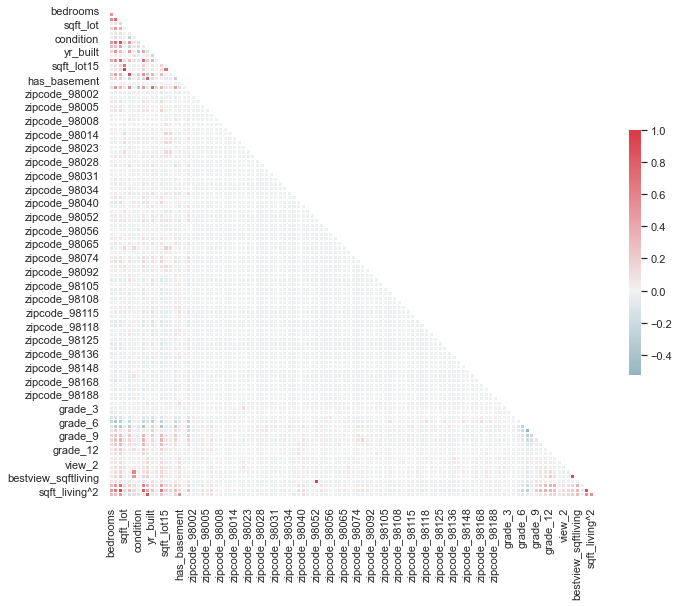

In [266]:
sns.set(style="white")


# Compute the correlation matrix
corr = df_features.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
df_features.shape

In [ ]:
target.shape

In [ ]:
df_features.head()

In [ ]:
Jaxs_fancy_model.predict(df_features)

In [181]:
Jaxs_fancy_model=LinearRegression()
Jaxs_fancy_model=Jaxs_fancy_model.fit(df_features, org_hous_df['price'])

In [183]:
import pickle

pickle_out = open("Jaxs_fancy_model.pickle","wb")

pickle.dump(Jaxs_fancy_model, pickle_out)

pickle_out.close()

In [184]:
pickle_out = open("column_selection.pickle","wb")

pickle.dump(df_features.columns, pickle_out)

pickle_out.close()

## Step 7: Compare the RMSE of your different models that use different features and determine the best model overall.

## Step 8:  Refit your best model to the entire dataset.

## Step 9: Save your final model using pickle.

https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/